## Imports and utility functions


In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob



## Introduction
The functions below provide the capability to calculate important measures of a particle precipitation model based on a given map of precipitation (MLAT-MLT grid and total electron energy flux values on that grid)

Parameters examined below are:
- Hemispheric Power
- Auroral boundaries

The functionality can be read into any Jupyter notebook with the following command (assuming that this notebook is located in the same directory):

*%run Precipitation_Model_Evaluation_Utilities.ipynb*


In [3]:
%matplotlib inline
# Note during development: create an ovation grid and map for testing these functions
import matplotlib.pyplot as plt
from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux

datetime_test = datetime.datetime(2017,1,31,1,1,1)

a_type = 'diff'
j_type = 'energy'
estimator = ovation_prime.FluxEstimator(a_type,energy_or_number=j_type)
mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation = estimator.get_flux_for_time(datetime_test,
                                                                                 hemi='N',
                                                                                 return_dF=False,
                                                                                 combine_hemispheres=True,)


# # Plot
# f = plt.figure(figsize=(12,6),dpi=150)
# axN = f.add_subplot(111,projection='polar')
# pcolor_kwargs = {'cmap':'gnuplot'}
# mappableN = pcolor_flux(axN,
#                         mlat_grid_ovation, 
#                         mlt_grid_ovation,
#                         eFlux_ovation,
#                         'N',
#                         **pcolor_kwargs)
# f.colorbar(mappableN,ax=axN,label=j_type)
# axN.set_title('Northern Hemisphere')
# polar2dial(axN)
# f.suptitle(('%s, %s' % (a_type,j_type)))
# plt.show()


YR NaNd 0/8760 (fill was -2147483648.0)
Day NaNd 0/8760 (fill was -2147483648.0)
HR NaNd 0/8760 (fill was -2147483648.0)
(8760,)
YR NaNd 0/8760 (fill was -2147483648.0)
Day NaNd 0/8760 (fill was -2147483648.0)
HR NaNd 0/8760 (fill was -2147483648.0)
(8760,)
BX_GSE NaNd 0/72 (fill was 999.90002)
BY_GSM NaNd 0/72 (fill was 999.90002)
BZ_GSM NaNd 0/72 (fill was 999.90002)
V NaNd 0/72 (fill was 9999.0)
N NaNd 0/72 (fill was 999.90002)


In [4]:
# Calculate total electron energy flux
auroral_flux_types = ['diff','mono','wave']

flag = 0
for a_type in auroral_flux_types:
    print('working on auroral_flux_type = {}'.format(a_type))
    estimator_e = ovation_prime.FluxEstimator(a_type,energy_or_number='energy')
    mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_tmp = estimator_e.get_flux_for_time(datetime_test,
                                                                                           hemi='N',
                                                                                           return_dF=False,
                                                                                           combine_hemispheres=True,)

    if flag == 0:
        eFlux_ovation_full = eFlux_ovation_tmp
        flag = 1
    elif flag == 1:
        eFlux_ovation_full = eFlux_ovation_full + eFlux_ovation_tmp


working on auroral_flux_type = diff
BX_GSE NaNd 0/72 (fill was 999.90002)
BY_GSM NaNd 0/72 (fill was 999.90002)
BZ_GSM NaNd 0/72 (fill was 999.90002)
V NaNd 0/72 (fill was 9999.0)
N NaNd 0/72 (fill was 999.90002)
working on auroral_flux_type = mono
BX_GSE NaNd 0/72 (fill was 999.90002)
BY_GSM NaNd 0/72 (fill was 999.90002)
BZ_GSM NaNd 0/72 (fill was 999.90002)
V NaNd 0/72 (fill was 9999.0)
N NaNd 0/72 (fill was 999.90002)
working on auroral_flux_type = wave
BX_GSE NaNd 0/72 (fill was 999.90002)
BY_GSM NaNd 0/72 (fill was 999.90002)
BZ_GSM NaNd 0/72 (fill was 999.90002)
V NaNd 0/72 (fill was 9999.0)
N NaNd 0/72 (fill was 999.90002)


#### Hemispheric Power

##### Approaches:
- Method for complete global maps of precipitation [Luan et al., 2016](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2016JA022730): "For each UT, the auroral  hemispheric  power  (HP)  is integrated hemispherically from the averaged energy of each MLAT-MLON grid in the latitudinal range of50–90 MLAT over all 0–360 MLONs (equivalent to 0–24 MLT). Note that the geographic area of each MLAT-MLON grid is used to calculate the auroral power in it for both hemispheres. For each selected MLAT-MLON grid (1.0° × 15°), the geographic locations of its four edges arefirst calculated, and then the geographic areas are determined using a general method to calculate the areasof spherical polygons. The integrated HP using these geographic areas in the MLAT-MLON grids is equivalentto that integrated in case of binning auroral energyflux in geographic coordinates (not shown). Due to thefact that the Earth’s magneticfield is not a dipole, the geographic area in a uniform MLAT-MLON grid is long-itudinal dependent [Laundal and Gjerloev, 2014], especially in the Southern Hemisphere; thus, it will have acontribution to the longitudinal pattern of HP. "
- Method for individual satellite passes of precipitation [Emery et al., 2008 approach](http://cedarweb.vsp.ucar.edu/wiki/index.php/Tools_and_Models:Emery_HP_plus_indices_to_11107): *description here*
- [Newell et al., 2010c approach](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010SW000604)
- [Using local SuperMAG indices](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JA020524)

##### Comparison data sets
- Estimates from Polar UVI images:
    - [Newell et al., 2010c](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010SW000604) (NOTE: could request their database from Jesper Gjerloev or during visit to APL)
    - [Cardoso et al., 2017](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JA023780) (NOTE: requested their database on 12/26/2019)

- Estimates from DMSP GUVI and/or SSUSI images:
    - FUV auroral imagers on TIMED/GUVI and DMSP/SSUSI provide global auroral coverage (1/2 to 1/3 of the auroral oval). The auroral products from the FUV data include maps of electron energy flux (Q) and mean energy (E0), peak E region density and height, height integrated conductance, **hemispheric power**, equatorward auroral boundary (swath and global), poleward boundary (swath and global). The auroral data products are available 2002-2007 (GUVI), 2004-present (SSUSI on DMSP F16), 2006-present (SSUSI on F17) and 2009-present (SSUSI on F18)


In [52]:
def hemispheric_power_from_grid(mlat_grid,mlt_grid,eflux_grid):
    ''' 
        mlat_grid = nxm grid of MLAT values
        mlt_grid = nxm grid of MLT values
        eflux_grid = nxm grid of total electron energy flux values [W/m2]
          --> n == number of distinct MLATS
          --> m == number of distinct MLTS

        Dependencies:
          - area (https://pypi.org/project/area/)
        
    '''
    from area import area

    bin_surfarea = np.zeros_like(mlat_grid)
    bin_power = np.zeros_like(mlat_grid)

    mlon_grid = mlt_grid * 15
    for i in range(mlat_grid.shape[0]-1):
        for j in range(mlat_grid.shape[1]-1):
#             print('current grid point = {}-{} MLAT-MLT'.format(mlat_grid[i,j],mlt_grid[i,j]))

            # Calculate the bin's surface area
            mlat1 = mlat_grid[i,j]
            mlat2 = mlat_grid[i+1,j]
            mlon1 = mlon_grid[i,j]
            mlon2 = mlon_grid[i,j+1]
            geom = {'type': 'Polygon',
                    'coordinates': [[[mlon1, mlat1], [mlon2, mlat1],
                                     [mlon2, mlat2], [mlon1, mlat2],
                                     [mlon1, mlat1]]]}
            bin_surfarea[i,j] = area(geom)
            bin_power[i,j] = eflux_grid[i,j] * bin_surfarea[i,j]

    HP = np.nansum(np.nansum(bin_power))

    return HP#, bin_surfarea, bin_power

In [31]:
### Testing 'hemispheric_power_from_grid'

# eFlux_ovation_converted = eFlux_ovation * (100**2) / 1e7
# eFlux_ovation_full_converted = eFlux_ovation_full * (100**2) / 1e7
# from area import area

# bin_surfarea = np.zeros_like(mlat_grid_ovation)
# bin_power = np.zeros_like(mlat_grid_ovation)

# mlon_grid_ovation = mlt_grid_ovation * 15
# for i in range(mlat_grid_ovation.shape[0]-1):
#     for j in range(mlat_grid_ovation.shape[1]-1):
#         print('current grid point = {}-{} MLAT-MLT'.format(mlat_grid_ovation[i,j],mlt_grid_ovation[i,j]))

#         # Calculate the bin's surface area
#         mlat1 = mlat_grid_ovation[i,j]
#         mlat2 = mlat_grid_ovation[i+1,j]
#         mlon1 = mlon_grid_ovation[i,j]
#         mlon2 = mlon_grid_ovation[i,j+1]
#         geom = {'type': 'Polygon',
#                 'coordinates': [[[mlon1, mlat1], [mlon2, mlat1],
#                                  [mlon2, mlat2], [mlon1, mlat2],
#                                  [mlon1, mlat1]]]}
#         bin_surfarea[i,j] = area(geom)
#         print('bin surface area for mlon1, mlat1 = {}'.format(bin_surfarea[i,j]))
#         bin_power[i,j] = eFlux_ovation_converted[i,j] * bin_surfarea[i,j]
#         print('bin power area for mlon1, mlat1 = {}\n\n'.format(bin_power[i,j]))

# print('{:.4E}'.format(sum(sum(bin_power))/2))

current grid point = 50.0-0.0 MLAT-MLT
bin surface area for mlon1, mlat1 = 15202782555.98406
bin power area for mlon1, mlat1 = 145077.1994312154


current grid point = 50.0-0.25263157894736843 MLAT-MLT
bin surface area for mlon1, mlat1 = 15202782555.98406
bin power area for mlon1, mlat1 = 146170.1147580271


current grid point = 50.0-0.5052631578947369 MLAT-MLT
bin surface area for mlon1, mlat1 = 15202782555.98406
bin power area for mlon1, mlat1 = 148289.03588904566


current grid point = 50.0-0.7578947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 15202782555.983778
bin power area for mlon1, mlat1 = 108419.22580675305


current grid point = 50.0-1.0105263157894737 MLAT-MLT
bin surface area for mlon1, mlat1 = 15202782555.98406
bin power area for mlon1, mlat1 = 100079.28536008159


current grid point = 50.0-1.263157894736842 MLAT-MLT
bin surface area for mlon1, mlat1 = 15202782555.98406
bin power area for mlon1, mlat1 = 91739.34491340812


current grid point = 50.0-1.51578947368


current grid point = 53.54430379746835-11.115789473684211 MLAT-MLT
bin surface area for mlon1, mlat1 = 14043541201.239614
bin power area for mlon1, mlat1 = 357036.7890954886


current grid point = 53.54430379746835-11.368421052631579 MLAT-MLT
bin surface area for mlon1, mlat1 = 14043541201.239614
bin power area for mlon1, mlat1 = 313401.4209495932


current grid point = 53.54430379746835-11.621052631578948 MLAT-MLT
bin surface area for mlon1, mlat1 = 14043541201.239614
bin power area for mlon1, mlat1 = 300799.18974963686


current grid point = 53.54430379746835-11.873684210526315 MLAT-MLT
bin surface area for mlon1, mlat1 = 1320092872916.5461
bin power area for mlon1, mlat1 = 26653182.24671524


current grid point = 53.54430379746835--11.873684210526315 MLAT-MLT
bin surface area for mlon1, mlat1 = 14043541201.239614
bin power area for mlon1, mlat1 = 288427.93872062495


current grid point = 53.54430379746835--11.621052631578946 MLAT-MLT
bin surface area for mlon1, mlat1 = 14043541201.

bin surface area for mlon1, mlat1 = 12830577527.263515
bin power area for mlon1, mlat1 = 306384.16759609827


current grid point = 57.08860759493671-11.621052631578948 MLAT-MLT
bin surface area for mlon1, mlat1 = 12830577527.263798
bin power area for mlon1, mlat1 = 298213.4823726109


current grid point = 57.08860759493671-11.873684210526315 MLAT-MLT
bin surface area for mlon1, mlat1 = 1206074287562.7659
bin power area for mlon1, mlat1 = 26328235.928506963


current grid point = 57.08860759493671--11.873684210526315 MLAT-MLT
bin surface area for mlon1, mlat1 = 12830577527.263798
bin power area for mlon1, mlat1 = 248304.04847438497


current grid point = 57.08860759493671--11.621052631578946 MLAT-MLT
bin surface area for mlon1, mlat1 = 12830577527.263515
bin power area for mlon1, mlat1 = 247848.65605890003


current grid point = 57.08860759493671--11.368421052631579 MLAT-MLT
bin surface area for mlon1, mlat1 = 12830577527.263798
bin power area for mlon1, mlat1 = 148480.40518910688


cur

current grid point = 61.139240506329116--4.294736842105262 MLAT-MLT
bin surface area for mlon1, mlat1 = 11384511937.534279
bin power area for mlon1, mlat1 = 677133.8448861317


current grid point = 61.139240506329116--4.042105263157893 MLAT-MLT
bin surface area for mlon1, mlat1 = 11384511937.534279
bin power area for mlon1, mlat1 = 776234.0749859234


current grid point = 61.139240506329116--3.7894736842105274 MLAT-MLT
bin surface area for mlon1, mlat1 = 11384511937.534279
bin power area for mlon1, mlat1 = 1035722.4504902774


current grid point = 61.139240506329116--3.5368421052631582 MLAT-MLT
bin surface area for mlon1, mlat1 = 11384511937.534279
bin power area for mlon1, mlat1 = 1067275.0681345453


current grid point = 61.139240506329116--3.284210526315789 MLAT-MLT
bin surface area for mlon1, mlat1 = 11384511937.534279
bin power area for mlon1, mlat1 = 1269938.0726650595


current grid point = 61.139240506329116--3.03157894736842 MLAT-MLT
bin surface area for mlon1, mlat1 = 1138451

current grid point = 65.18987341772151-6.315789473684211 MLAT-MLT
bin surface area for mlon1, mlat1 = 9881569694.620644
bin power area for mlon1, mlat1 = 9108831.17791417


current grid point = 65.18987341772151-6.568421052631579 MLAT-MLT
bin surface area for mlon1, mlat1 = 9881569694.620644
bin power area for mlon1, mlat1 = 8014991.193093235


current grid point = 65.18987341772151-6.821052631578947 MLAT-MLT
bin surface area for mlon1, mlat1 = 9881569694.620644
bin power area for mlon1, mlat1 = 7739711.596144464


current grid point = 65.18987341772151-7.0736842105263165 MLAT-MLT
bin surface area for mlon1, mlat1 = 9881569694.620644
bin power area for mlon1, mlat1 = 6549903.614791569


current grid point = 65.18987341772151-7.326315789473685 MLAT-MLT
bin surface area for mlon1, mlat1 = 9881569694.620644
bin power area for mlon1, mlat1 = 5564033.878375742


current grid point = 65.18987341772151-7.578947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 9881569694.620644
bin power 

current grid point = 69.74683544303798-0.7578947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 8132133305.225489
bin power area for mlon1, mlat1 = 5024966.89363952


current grid point = 69.74683544303798-1.0105263157894737 MLAT-MLT
bin surface area for mlon1, mlat1 = 8132133305.225205
bin power area for mlon1, mlat1 = 4715247.588872946


current grid point = 69.74683544303798-1.263157894736842 MLAT-MLT
bin surface area for mlon1, mlat1 = 8132133305.225205
bin power area for mlon1, mlat1 = 4573598.59142094


current grid point = 69.74683544303798-1.5157894736842106 MLAT-MLT
bin surface area for mlon1, mlat1 = 8132133305.225205
bin power area for mlon1, mlat1 = 4704571.556963723


current grid point = 69.74683544303798-1.7684210526315791 MLAT-MLT
bin surface area for mlon1, mlat1 = 8132133305.225205
bin power area for mlon1, mlat1 = 4716885.730097777


current grid point = 69.74683544303798-2.0210526315789474 MLAT-MLT
bin surface area for mlon1, mlat1 = 8132133305.225489
bin pow

current grid point = 72.27848101265823-7.0736842105263165 MLAT-MLT
bin surface area for mlon1, mlat1 = 7137286119.436417
bin power area for mlon1, mlat1 = 5456267.8787619835


current grid point = 72.27848101265823-7.326315789473685 MLAT-MLT
bin surface area for mlon1, mlat1 = 7137286119.436417
bin power area for mlon1, mlat1 = 5755623.371827004


current grid point = 72.27848101265823-7.578947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 7137286119.436417
bin power area for mlon1, mlat1 = 5795539.978766015


current grid point = 72.27848101265823-7.831578947368421 MLAT-MLT
bin surface area for mlon1, mlat1 = 7137286119.436417
bin power area for mlon1, mlat1 = 5948149.677256992


current grid point = 72.27848101265823-8.08421052631579 MLAT-MLT
bin surface area for mlon1, mlat1 = 7137286119.436417
bin power area for mlon1, mlat1 = 5924985.624063425


current grid point = 72.27848101265823-8.336842105263159 MLAT-MLT
bin surface area for mlon1, mlat1 = 7137286119.436417
bin power

bin surface area for mlon1, mlat1 = 5721534056.722921
bin power area for mlon1, mlat1 = 1178755.0704584818


current grid point = 75.82278481012659-7.578947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 5721534056.722921
bin power area for mlon1, mlat1 = 1243394.1163289677


current grid point = 75.82278481012659-7.831578947368421 MLAT-MLT
bin surface area for mlon1, mlat1 = 5721534056.722921
bin power area for mlon1, mlat1 = 1399202.0652853858


current grid point = 75.82278481012659-8.08421052631579 MLAT-MLT
bin surface area for mlon1, mlat1 = 5721534056.722921
bin power area for mlon1, mlat1 = 1392392.2216111075


current grid point = 75.82278481012659-8.336842105263159 MLAT-MLT
bin surface area for mlon1, mlat1 = 5721534056.722921
bin power area for mlon1, mlat1 = 1491343.7078041367


current grid point = 75.82278481012659-8.589473684210526 MLAT-MLT
bin surface area for mlon1, mlat1 = 5721534056.722921
bin power area for mlon1, mlat1 = 1490553.2812547442


current grid poin

bin power area for mlon1, mlat1 = 88894.66098348486


current grid point = 80.37974683544304-2.0210526315789474 MLAT-MLT
bin surface area for mlon1, mlat1 = 3869888461.0693407
bin power area for mlon1, mlat1 = 98505.22989462843


current grid point = 80.37974683544304-2.2736842105263158 MLAT-MLT
bin surface area for mlon1, mlat1 = 3869888461.0687757
bin power area for mlon1, mlat1 = 141475.93861543888


current grid point = 80.37974683544304-2.526315789473684 MLAT-MLT
bin surface area for mlon1, mlat1 = 3869888461.0693407
bin power area for mlon1, mlat1 = 104873.5459294976


current grid point = 80.37974683544304-2.778947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 3869888461.0687757
bin power area for mlon1, mlat1 = 129654.99783580343


current grid point = 80.37974683544304-3.031578947368421 MLAT-MLT
bin surface area for mlon1, mlat1 = 3869888461.0687757
bin power area for mlon1, mlat1 = 103572.25261126806


current grid point = 80.37974683544304-3.2842105263157895 MLAT-MLT

current grid point = 84.43037974683544-17.936842105263157 MLAT-MLT
bin surface area for mlon1, mlat1 = 2203073494.4292603
bin power area for mlon1, mlat1 = 31595.453021034056


current grid point = 84.43037974683544-18.189473684210526 MLAT-MLT
bin surface area for mlon1, mlat1 = 2203073494.4292603
bin power area for mlon1, mlat1 = 33400.157885253924


current grid point = 84.43037974683544-18.442105263157895 MLAT-MLT
bin surface area for mlon1, mlat1 = 2203073494.4292603
bin power area for mlon1, mlat1 = 33698.22063661288


current grid point = 84.43037974683544-18.694736842105264 MLAT-MLT
bin surface area for mlon1, mlat1 = 2203073494.429825
bin power area for mlon1, mlat1 = 36263.11771302964


current grid point = 84.43037974683544-18.947368421052634 MLAT-MLT
bin surface area for mlon1, mlat1 = 2203073494.4292603
bin power area for mlon1, mlat1 = 32348.87454761921


current grid point = 84.43037974683544-19.2 MLAT-MLT
bin surface area for mlon1, mlat1 = 2203073494.4292603
bin power a

bin surface area for mlon1, mlat1 = 735295433.9289441
bin power area for mlon1, mlat1 = 11579.60543144479


current grid point = 87.9746835443038-20.96842105263158 MLAT-MLT
bin surface area for mlon1, mlat1 = 735295433.9289441
bin power area for mlon1, mlat1 = 13888.533758972995


current grid point = 87.9746835443038-21.22105263157895 MLAT-MLT
bin surface area for mlon1, mlat1 = 735295433.9289441
bin power area for mlon1, mlat1 = 13303.236824637874


current grid point = 87.9746835443038-21.473684210526315 MLAT-MLT
bin surface area for mlon1, mlat1 = 735295433.9289441
bin power area for mlon1, mlat1 = 13691.928345497803


current grid point = 87.9746835443038-21.726315789473684 MLAT-MLT
bin surface area for mlon1, mlat1 = 735295433.9289441
bin power area for mlon1, mlat1 = 13823.60800400783


current grid point = 87.9746835443038-21.978947368421053 MLAT-MLT
bin surface area for mlon1, mlat1 = 735295433.9289441
bin power area for mlon1, mlat1 = 9251.054113700417


current grid point = 

In [51]:
### Testing 'hemispheric_power_from_grid'


# eFlux_ovation_converted = eFlux_ovation * (100**2) / 1e7 
# eFlux_ovation_full_converted = eFlux_ovation_full * (100**2) / 1e7

# # HP, bin_surfarea, bin_power = hemispheric_power_from_grid(mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_converted)
# HP = hemispheric_power_from_grid(mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_converted)
# print('{:.4E} and {:.4E} for one hemisphere alone'.format( HP,HP/2. ))
# HP_full = hemispheric_power_from_grid(mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_full_converted)
# print('{:.4E} and {:.4E} for one hemisphere alone'.format( HP_full,HP_full/2. ))



2.0132E+10 and 1.0066E+10 for one hemisphere alone
3.1607E+10 and 1.5804E+10 for one hemisphere alone



#### Auroral Boundary

##### Approaches:
- [CCMC Auroral boundary validation plan](https://ccmc.gsfc.nasa.gov/challenges/AuroralOval/auroral_boundary_validation_plan.php)
    - The auroral boundaries in the GUVI and SSUSI data products are defined as the location where the electron energy flux at a fixed level: 0.2 ergs/s/cm2
    - Recommendation: Use energy flux ("It is important to note that there are other definitions of auroral boundaries, such as gradient based, region based (open-closed), and magnetic field stretch. These definitions are useful for various purposes. However, the most important is the electron energy flux which determines the strength of MI coupling as well as the magnitude of thermosphere response.")

##### Comparison data sets
- DMSP auroral boundaries data (available from 2010-2014) as detailed in "[A new DMSP magnetometer and auroral boundary data set and estimates of field‐aligned currents in dynamic auroral boundary coordinates](https://doi.org/10.1002/2016JA023342)"
- Auroral imagery data from various satellites and ground-based imagers using a threshold of flux to find the boundaries

In [116]:
def auroral_boundaries_from_grid(mlat_grid,mlt_grid,eflux_grid):
    ''' 
        mlat_grid = nxm grid of MLAT values
        mlt_grid = nxm grid of MLT values
        eflux_grid = nxm grid of total electron energy flux values [erg/cm2/s]
          --> n == number of distinct MLATS
          --> m == number of distinct MLTS

        Dependencies:
          - ...
        
    '''
    
    mlt_eq_boundary = np.zeros(mlt_grid.shape[1])
    mlt_pol_boundary = np.zeros(mlt_grid.shape[1])

    for i in range(mlt_grid.shape[1]):
#         print('Boundary determination for MLT = {}'.format(mlt_grid[0,i]))

        idx_tmp = np.argwhere(eflux_grid[:,i] > 0.2)
        if len(idx_tmp)==0:
            print('no boundary found, returning NaN')
            mlt_eq_boundary[i] = np.nan
            mlt_pol_boundary[i] = np.nan
        else:
            mlt_eq_boundary[i] = mlat_grid[idx_tmp[0],0]
            mlt_pol_boundary[i] = mlat_grid[idx_tmp[-1],0]

#     auroral_boundaries = np.column_stack( (mlt_grid[-1,:].flatten(),mlt_eq_boundary.flatten(),mlt_pol_boundary.flatten()) )

    df_auroral_boundaries = pd.DataFrame(np.column_stack( (mlt_grid[-1,:].flatten(),mlt_eq_boundary.flatten(),mlt_pol_boundary.flatten()) ),
                                         columns=['mlt','eq colatitude', 'pol colatitude'])
    df_auroral_boundaries = df_auroral_boundaries.set_index('mlt')                                           
    df_auroral_boundaries['smoothed eq colatitude'] = df_auroral_boundaries['eq colatitude'].rolling(window=3).mean()
    df_auroral_boundaries['smoothed pol colatitude'] = df_auroral_boundaries['pol colatitude'].rolling(window=3).mean()

    df_auroral_boundaries['smoothed eq colatitude'] = df_auroral_boundaries['smoothed eq colatitude'].bfill()
    df_auroral_boundaries['smoothed eq colatitude'].iloc[0] = df_auroral_boundaries['smoothed eq colatitude'].iloc[-1]
    df_auroral_boundaries['smoothed pol colatitude'] = df_auroral_boundaries['smoothed pol colatitude'].bfill()
    df_auroral_boundaries['smoothed pol colatitude'].iloc[0] = df_auroral_boundaries['smoothed pol colatitude'].iloc[-1]

    return df_auroral_boundaries

    

Boundary determination for MLT = 0.0
Boundary determination for MLT = 0.25263157894736843
Boundary determination for MLT = 0.5052631578947369
Boundary determination for MLT = 0.7578947368421053
Boundary determination for MLT = 1.0105263157894737
Boundary determination for MLT = 1.263157894736842
Boundary determination for MLT = 1.5157894736842106
Boundary determination for MLT = 1.7684210526315791
Boundary determination for MLT = 2.0210526315789474
Boundary determination for MLT = 2.2736842105263158
Boundary determination for MLT = 2.526315789473684
Boundary determination for MLT = 2.778947368421053
Boundary determination for MLT = 3.031578947368421
Boundary determination for MLT = 3.2842105263157895
Boundary determination for MLT = 3.5368421052631582
Boundary determination for MLT = 3.7894736842105265
Boundary determination for MLT = 4.042105263157895
Boundary determination for MLT = 4.294736842105263
Boundary determination for MLT = 4.5473684210526315
Boundary determination for MLT =

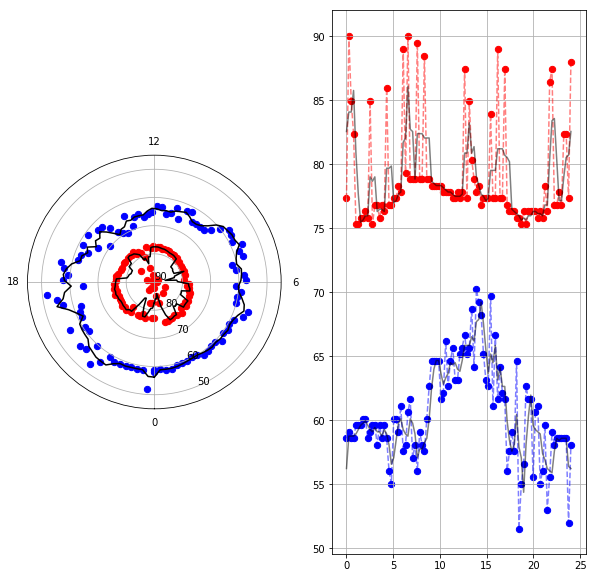

In [104]:
# # Below is a script to test the auroral boundary identification and plot
#     --> useful for use in scripts that call the auroral boundary function above

# df_mlt_boundaries = auroral_boundaries_from_grid(mlat_grid_ovation,mlt_grid_ovation,eFlux_ovation_full)

# # Check by plotting
# from matplotlib.gridspec import GridSpec

# fig = plt.figure(figsize=(10,10))

# gs = GridSpec(1,2, figure=fig)

# # Create polar plot
# ax1 = fig.add_subplot(gs[0,0],polar=True)
# ctf1 = ax1.scatter(df_mlt_boundaries.index*15.* (np.pi/180.), 
#                   90. - df_mlt_boundaries['eq colatitude'],
#                   s = 40,
#                   c = 'b')
# ctf1 = ax1.scatter(df_mlt_boundaries.index*15.* (np.pi/180.), 
#                   90. - df_mlt_boundaries['pol colatitude'],
#                   s = 40,
#                   c = 'r')
# ctf1 = ax1.plot(df_mlt_boundaries.index*15.* (np.pi/180.), 
#                 90. - df_mlt_boundaries['smoothed eq colatitude'],
#                 c = 'k')
# ctf1 = ax1.plot(df_mlt_boundaries.index*15.* (np.pi/180.), 
#                 90. - df_mlt_boundaries['smoothed pol colatitude'],
#                 c = 'k')



# # define your axis limits
# ax1.set_ylim([0,45])

# # Set the radius labels
# ax1.set_yticks(np.arange(0,50,10))  # less radial ticks
# ax1.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# # Set the circumference labels
# ax1.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
# ax1.set_xticklabels(('0','6','12','18'))      

# ax1.grid(True)
# ax1.set_theta_zero_location("S")



# # Create polar plot
# ax2 = fig.add_subplot(gs[0,1],polar=False)
# ctf1 = ax2.scatter(df_mlt_boundaries.index, 
#                    df_mlt_boundaries['eq colatitude'],
#                    s = 40,
#                    c = 'b')
# ax2.plot(mlt_grid_ovation[-1,:], 
#          df_mlt_boundaries['eq colatitude'],
#          '--',
#          alpha = 0.5,
#          c = 'b')
# ax2.plot(df_mlt_boundaries.index, 
#          df_mlt_boundaries['smoothed eq colatitude'],
#          alpha = 0.5,
#          c = 'k')
# ctf2 = ax2.scatter(df_mlt_boundaries.index, 
#                    df_mlt_boundaries['pol colatitude'],
#                    s = 40,
#                    c = 'r')
# ax2.plot(df_mlt_boundaries.index, 
#          df_mlt_boundaries['pol colatitude'],
#          '--',
#          alpha = 0.5,
#          c = 'r')
# ax2.plot(df_mlt_boundaries.index, 
#          df_mlt_boundaries['smoothed pol colatitude'],
#          alpha = 0.5,
#          c = 'k')
# ax2.grid(True)

#### Calculate precipitation model output at locations of DMSP validation observational data

- NOTE: this function was written specifically to work with the OVATION Prime model, though could be revised for a different model by supplying the mlat and mlt grid in appropriate form and replacing the OVATION calculation using ovationpyme with the means to calculate the other model for a given datetime



In [ ]:
def interpolate_grid_to_DMSP(mlat_grid,mlt_grid,df_obs,t_step):
    '''
    INPUT: 
        mlat_grid = nxm grid of MLAT values
        mlt_grid = nxm grid of MLT values
        model_grid = nxm grid of model values 
          --> n == number of distinct MLATS
          --> m == number of distinct MLTS
        df_obs = dataframe of observation locations
          --> index are datetimes of each observation
          --> 'mlat' = column of magnetic latitude values
          --> 'mlt' = column of magnetic local time values
        t_step = number of steps in the 'df_obs' datetimes to take between evaluations of the model 
                    (e.g., 10 would mean calculating the model values uniquely only every 10 
                     datetimes in the data)

    OUTPUT: 
        df_idxs = dataframe that identifies the model points and values corresponding to the observation location
          --> 'mlat' = observation magnetic latitude location
          --> 'mlt' = observation magnetic local time location
          --> 'grid idx mlat' = index to model grid magnetic latitude (mlat_grid[idx,0])
          --> 'grid idx mlt' = index to model grid magnetic local time (mlt_grid[0,idx])
          --> 'model value' = value of the model at the closest grid point of the observation
                    
    DEPENDENCIES:
        pandas: https://pandas.pydata.org/
        ovationpyme: https://github.com/lkilcommons/OvationPyme
        
    # Sample code to create 'df_obs'
        df_obs = pd.DataFrame(np.column_stack((X_val['SC_AACGM_LAT'].values,
                                               X_val['SC_AACGM_LTIME'].values)),
                                               index = X_val.index.values,
                                               columns=['mlat','mlt'])
         
    '''
    
    print('NOTE: only use with t_step=1')
    
    import pandas as pd
    from ovationpyme import ovation_prime
    from ovationpyme import ovation_utilities
    


    model_idxs = np.zeros( (0,2),dtype=int )
    model_grid_vals = np.zeros( (0,2),dtype=float )
    model_values = np.zeros( (0,1),dtype=float )
    datetimes = np.zeros( (0,1),dtype='datetime64[s]' )

    auroral_flux_types = ['diff','mono','wave']
    
    for t in range(0,len(df_obs),t_step):

        # Calculate the ovation prime map for this datetime
        flag = 0
        for a_type in auroral_flux_types:
            print('working on auroral_flux_type = {}'.format(a_type))
            estimator_e = ovation_prime.FluxEstimator(a_type,energy_or_number='energy')
            _, _, eFlux_model_tmp = estimator_e.get_flux_for_time(df_obs.index[t],
                                                                    hemi=hemi,
                                                                    return_dF=False,
                                                                    combine_hemispheres=True,)

            if flag == 0:
                eFlux_model_full = eFlux_model_tmp
                flag = 1
            elif flag == 1:
                eFlux_model_full = eFlux_model_full + eFlux_model_tmp

    #     model_idxs[t,:] = [ nearest(mlat_grid[:,0],df_obs['mlat'][t]), nearest(mlt_grid[0,:],df_obs['mlt'][t]) ]
    #     model_values[t] = eFlux_model_full[model_idxs[t,0],model_idxs[t,1]]
    #     datetimes[t] = df_obs.index[t]
        model_idxs = np.append(model_idxs,
                           np.array([[ nearest(mlat_grid[:,0],df_obs['mlat'][t]), nearest(mlt_grid[-1,:],df_obs['mlt'][t]) ]]),
                           axis=0)

        model_grid_vals = np.append(model_grid_vals,
                                    [np.array( (mlat_grid[model_idxs[-1,0],0],mlt_grid[-1,model_idxs[-1,1]]) )],axis=0)
        model_values = np.append(model_values,np.array([[eFlux_model_full[model_idxs[-1,0],model_idxs[-1,1]]]]),axis=0)
        datetimes = np.append(datetimes,np.array([[df_obs.index[t]]]),axis=0)

    df_idxs = pd.DataFrame(np.column_stack((model_idxs[:,0],model_idxs[:,1],model_grid_vals[:,0],model_grid_vals[:,1],model_values)),
                           index = pd.to_datetime(datetimes.flatten()),
                           columns=['grid idx mlat',
                                    'grid idx mlt',
                                    'grid mlat',
                                    'grid mlt',
                                    'model value'])
    # Resample the model output to one minute
    df_idxs = df_idxs.resample('1T').pad()
    # This merge will only keep the values for which observations exist, so there will not be an issue filling
    #   model values across observational gaps
    df_out = pd.merge(df_obs,df_idxs, how='outer',left_index=True, right_index=True)#right_on=df_idxs.index)
    df_out = df_out.ffill()
#     df_out
    
    return df_out

In [3]:
# Some other needed functions for this analysis


def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df


  

In [5]:
# # sample call


# # Read in X_val data == F16 in 2010
# # file_read = '/Users/rmcgrana/Documents/DMSPdata/data/ML_DB_subsamp_ext_2010_sat_f16.csv'
# file_read = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/ML_DB_subsamp_ext_2010_sat_f16.csv'

# df_val = pd.read_csv(file_read)
# # converting southern hemisphere data to positive values
# col_idx = df_val.columns.get_loc('SC_AACGM_LAT')
# df_val.loc[df_val['SC_AACGM_LAT']<=-45.,'SC_AACGM_LAT'] = df_val.loc[df_val['SC_AACGM_LAT']<=-45.,'SC_AACGM_LAT'] * -1
# df_val[df_val['SC_AACGM_LAT']<=45.] = np.nan

# # Clean up the columns and redefine the datetime as the index
# df_val.index = pd.DatetimeIndex( df_val['Unnamed: 0'] )
# df_val.index.names = ['Datetimes']
# df_val.drop(['Unnamed: 0','key_0'], axis=1, inplace=True)
  
        
# # PREPARE DATA FOR ML

# # Remove outliers in the DB
# df_val = df_val.copy(deep=True)

# # IMF_outlier = 1000. #9999.99
# IMF_outlier = 200. #9999.99
# str_id = 'B'
# df_val = outlier_detect_and_replace(df_val,str_id,IMF_outlier)

# print('--------------------------------------------------------------')

# # vsw_outlier = 10000. #99999.9
# vsw_outlier = 2000. #99999.9
# str_id = 'vsw'
# df_val = outlier_detect_and_replace(df_val,str_id,vsw_outlier)

# print('--------------------------------------------------------------')

# # vsw_outlier = 10000. #99999.9
# vsw_outlier = 2000. #99999.9
# str_id = 'vx'
# df_val = outlier_detect_and_replace(df_val,str_id,vsw_outlier)

# print('--------------------------------------------------------------')

# # borovsky_outlier = 1e6 #df_val['borovsky'].quantile(.90)
# borovsky_outlier = 1e5 #df_val['borovsky'].quantile(.90)
# str_id = 'borovsky'
# df_val = outlier_detect_and_replace(df_val,str_id,borovsky_outlier)

# print('--------------------------------------------------------------')

# # newell_outlier = 1e5 #df_val['newell'].quantile(.90)
# newell_outlier = 9e3 #df_val['newell'].quantile(.90)
# str_id = 'newell'
# df_val = outlier_detect_and_replace(df_val,str_id,newell_outlier)

# df_val = df_val.dropna()

# #     save_filename = 'box_summary_DMSP_'+str(yr)+'.png'
# #     plot_box_summary(df_val,DMSP_FIGURE_DIR,save_filename) 


# # Drop unwanted features
# target_var = 'ELE_TOTAL_ENERGY_FLUX'
# cols_to_drop = [c for c in df_val.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c)]
# df_val = df_val.drop(cols_to_drop,axis=1)


# idx = np.argwhere( df_val['ELE_TOTAL_ENERGY_FLUX'].to_numpy()>np.quantile(df_val['ELE_TOTAL_ENERGY_FLUX'].to_numpy(),.999999) )
# df_val.iloc[idx,:] = np.nan
# df_val = df_val.dropna()


# # OVATION Prime performance on validation data
# df_val_function = pd.DataFrame(np.column_stack((df_val['SC_AACGM_LAT'].values,
#                                                df_val['SC_AACGM_LTIME'].values)),
#                               index = df_val.index.values,
#                               columns=['mlat','mlt'])


# # Get OVATION grid
# from ovationpyme import ovation_prime
# from ovationpyme import ovation_utilities

# numFluxThreshold = 5.0e7 # Value pulled from OvationPyme and used to set avg electron energies to zero for low number fluxes
# auroral_flux_types = ['diff']
# hemi = 'N'
# estimator = ovation_prime.FluxEstimator(auroral_flux_types[0],energy_or_number='energy')
# # Sample call and call once to get grid information
# mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_tmp = estimator.get_flux_for_time(df_val.index[0],
#                                                                                      hemi='N',
#                                                                                      return_dF=False,
#                                                                                      combine_hemispheres=True,)
# del eFlux_ovation_tmp




--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
Cached OMNI called for 2010-01-01 00:19:00
Created new OI: 2009-12-30 12:19:00-2010-01-02 12:19:00


In [ ]:
# # Evaluate OVATION Prime on validation observations
# df_val_ovation = interpolate_grid_to_DMSP(mlat_grid_ovation,mlt_grid_ovation,df_val_function,1)



In [17]:

# # in 34 minutes the evaluation only got to the beginning of Jan. 3, 2010
# idx_tmp = np.argwhere(df_val_function.index < datetime.datetime(2010,1,3,0,59,0))
# print('% = {}'.format( (max(idx_tmp)[0] / len(df_val_function))*100 ))
# print('expected time for full validation set = {} [hours]'.format( ((34/60) * 1) / (max(idx_tmp)[0] / len(df_val_function)) ))


% = 0.6140303211432918
expected time for full validation set = 92.28643067846608 [hours]
